<a href="https://colab.research.google.com/github/syedsajidhussain/Tract-segmentation/blob/main/visualization_distributions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quick analysis of fOD representations

When applying data augmentation such as additive Gaussian noise, we might want to account for differently distributed channels. For instance, if our input fODFs are in represented in a (truncated) spherical harmonics basis, one could assume that the there is higher variance in components representing lower frequencies. Applying the same noise to all the SH coefficients might dominate some channels completely while having low impact on others. Therefore, we might consider setting different augmentation parameters per channel. It is unclear, if similar assumptions can be made with the other representations (peaks, fODF tensors, fODF low rank approximation). Let's try to investigate this in this notebook.

## Setup

### Modules

In [ ]:
from pathlib import Path

import bonndit as bd
import matplotlib.pyplot as plt
import nibabel as nib
import nrrd
import numpy as np
import seaborn as sns

### Data

In [ ]:
# Arbitrarily chosen.
# Loading and averaging over all subjects would take a lot of time for probably little to no gain.
DIR_SUBJECT = "601127"

DIR_DATA = "/data/HCP"
DIR_PEAKS = "peaks"
DIR_FODFS = "mtdeconv"
DIR_RANKK = "fodf_low_rank"
FILENAME_PEAKS = "peaks_cropped.nii.gz"
FILENAME_FODFS = "fodf_preprocessed.nrrd"
FILENAME_FODFS_SH = "fodf_cropped_sh.nii.gz"
FILENAME_RANKK = "fodf_approx_rank_3_preprocessed.nii.gz"

path_subject = Path(DIR_DATA) / DIR_SUBJECT
path_peaks = path_subject / DIR_PEAKS / FILENAME_PEAKS
path_fodfs = path_subject / DIR_FODFS / FILENAME_FODFS
path_fodfs_sh = path_subject / DIR_FODFS / FILENAME_FODFS_SH
path_rankk = path_subject / DIR_RANKK / FILENAME_RANKK

### Utilities

In [ ]:
def load_nrrd(path):
    img, header_img = nrrd.read(path)
    return img, header_img


def load_nifti(path):
    img_nifti = nib.load(path)
    img = img_nifti.get_fdata()
    affine_img = img_nifti.affine
    return img, affine_img


def load_img(path):
    header_img, affine_img = None, None
    if path.suffixes == [".nrrd"]:
        img, header_img = load_nrrd(path)
    elif path.suffixes == [".nii", ".gz"]:
        img, affine_img = load_nifti(path)
    else:
        raise ValueError("Unsupported input file type.")

    return img, header_img, affine_img

## Plotting channel distributions

In [ ]:
peaks, _, _ = load_img(path_peaks)
fodfs, _, _ = load_img(path_fodfs)
fodfs_sh, _, _ = load_img(path_fodfs_sh)
rankk, _, _ = load_img(path_rankk)

display(peaks.shape)
display(fodfs.shape)
display(fodfs_sh.shape)
display(rankk.shape)

(113, 150, 112, 9)

(113, 150, 112, 15)

(113, 150, 112, 15)

(113, 150, 112, 9)

We don't care about spatial information here, so let's flatten these dimensions.

In [ ]:
def flatten_spatial(data):
    data_flattened = data.reshape(-1, data.shape[-1])
    return data_flattened

In [ ]:
peaks = flatten_spatial(peaks)
fodfs = flatten_spatial(fodfs)
fodfs_sh = flatten_spatial(fodfs_sh)
rankk = flatten_spatial(rankk)

Let's assume channels (feature space coefficients) are independent and plot these as distinct distributions.

In [ ]:
def plot_distributions(data, kde=True, filter=False, **kwargs):
    dina4_landscape = np.array([0.297, 0.21]) * 39.37
    fig = plt.figure(figsize=dina4_landscape)
    ax = fig.add_subplot(2, 1, 1)
    ax.set_title("Distributions of feature coefficients (channels)")
    ax.set_xlabel("Feature value")

    for c in range(data.shape[-1]):
        vals = data[:, c]

        if filter:
            # Note: we get differently laarge sets for different channels.
            # For KDE not a problem because of normalization.
            vals = vals[np.nonzero(vals)]

        if kde:
            ax = sns.kdeplot(vals, label=f"{c=}", **kwargs)
        else:
            ax = sns.histplot(vals, element="step", bins=100, alpha=0.1, label=f"{c=}", **kwargs)

    plt.legend()
    sns.move_legend(plt.gca(), "upper left", bbox_to_anchor=(1, 1))
    plt.show()

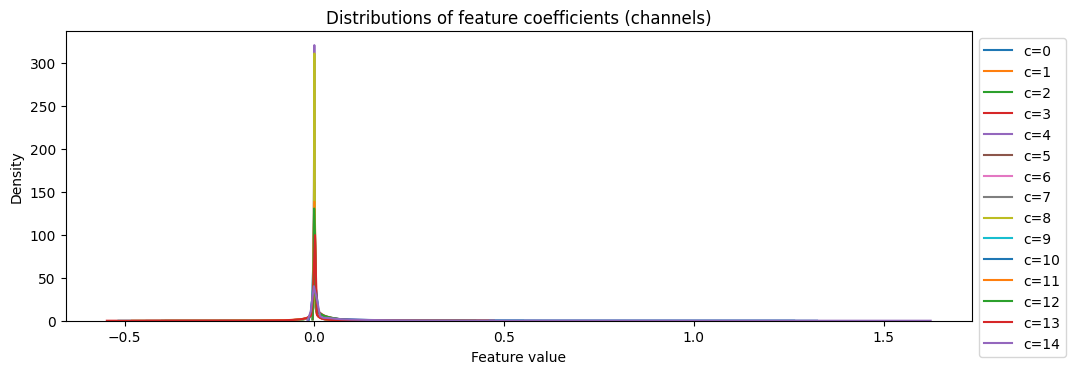

In [ ]:
plot_distributions(fodfs)

Great. As we can see, there is not much to see. To be sure, let's check using histograms instead of KDE.

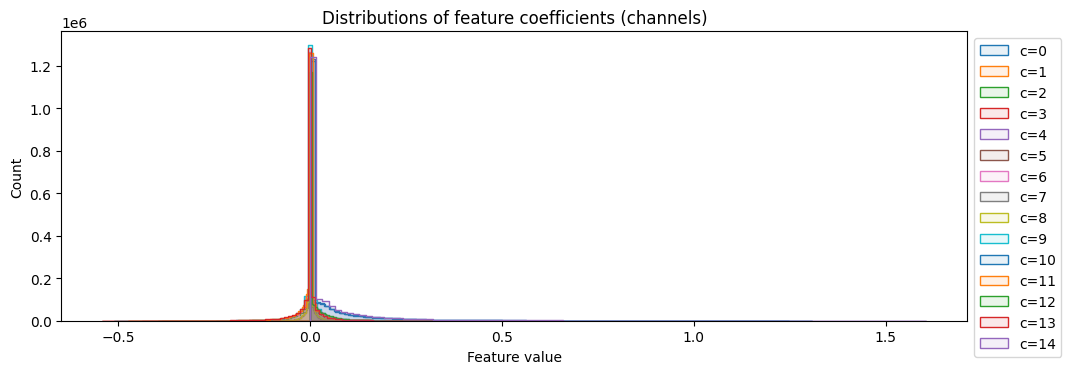

In [ ]:
plot_distributions(fodfs, kde=False)

Maybe the histogram is dominated by zero values (i.e. the data is sparse). Since fibers are not located in the entire volume (and the fact that the input is cropped to the brain area mitigates this greatly), filtering zero values might help for plotting, especially for peaks, as we just set them to zero if no fibers (or less than three) cross a voxel. For simplicity, let's filter channel-wise.

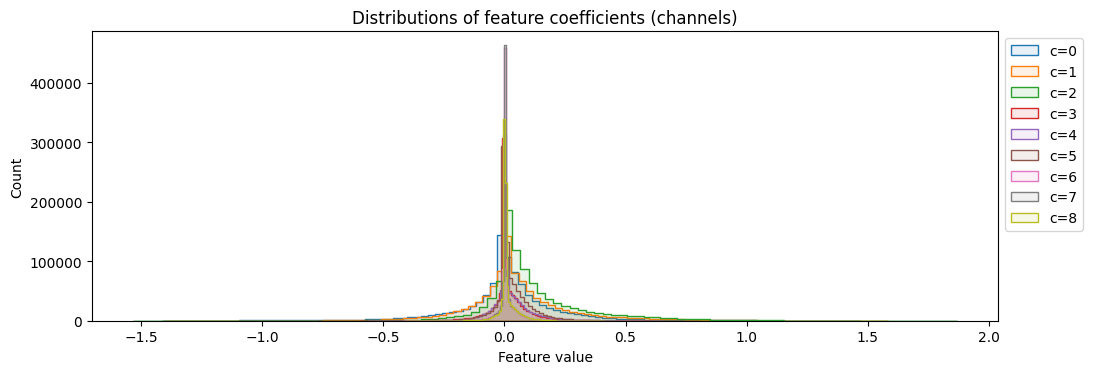

In [ ]:
plot_distributions(peaks, kde=False, filter=True)

Okay, so removing the zero values shows that still most values are very close to zero. We do not actually have sparse data but just distributions with very low variances.

Next, let's take the logarithm and only look at magnitudes. Filtering zeroes prevents computing $\log(0)$. Note that seaborn's log_scale parameter does not adjust the plot to be log scaled but acutally is a log transform applied to the data.

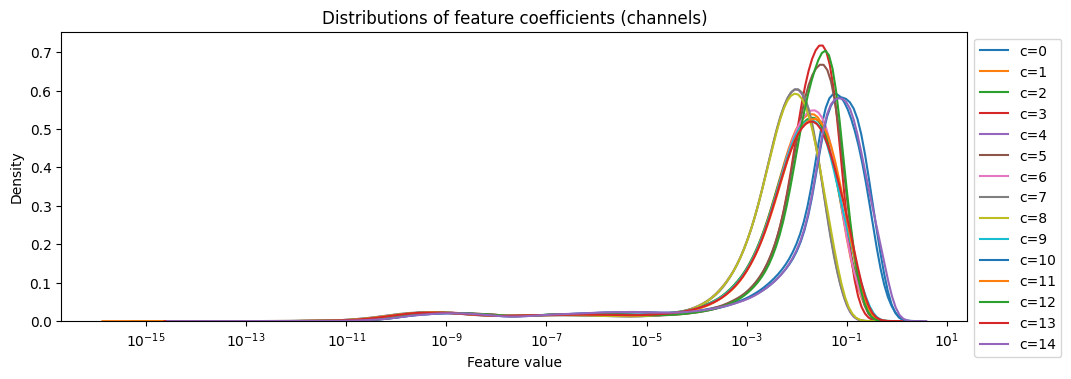

In [ ]:
plot_distributions(np.abs(fodfs), filter=True, log_scale=(True, False))

This seems to be at least somewhat useful. First we observe, most values are in a similar range. The distributions do differ significantly, but not drastically. Notably, this representation of $4$ th order fODF tensors exploits the symmetry to reduce $81$ coefficients to only $15$ unique ones. The number of times each of these $15$ components would occur in the written-out tensor varies. If we compare these numbers (see below) with the plot, there seems to be a (negative) correlation.

In [ ]:
order = bd.utils.tensor.get_order(fodfs[0])
display(bd.utils.tensor.MULTIPLIER[order])

[1.0, 4.0, 4.0, 6.0, 12.0, 6.0, 4.0, 12.0, 12.0, 4.0, 1.0, 4.0, 6.0, 4.0, 1.0]

## Comparison of representations

### Peaks

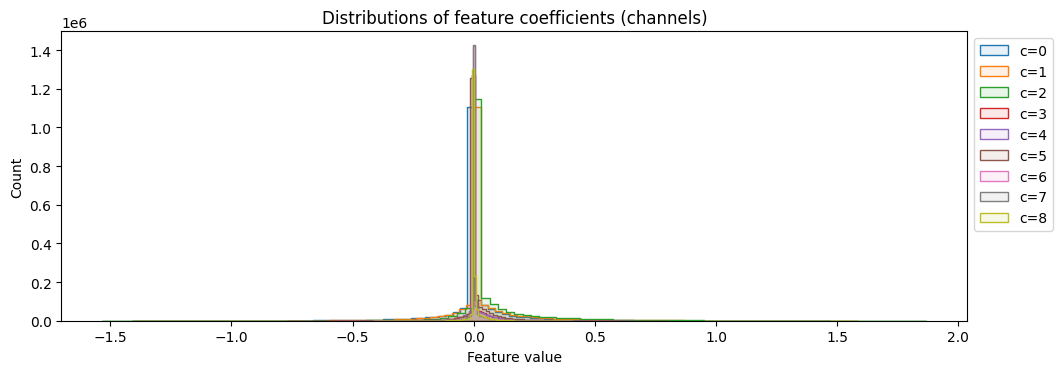

In [ ]:
plot_distributions(peaks, kde=False)

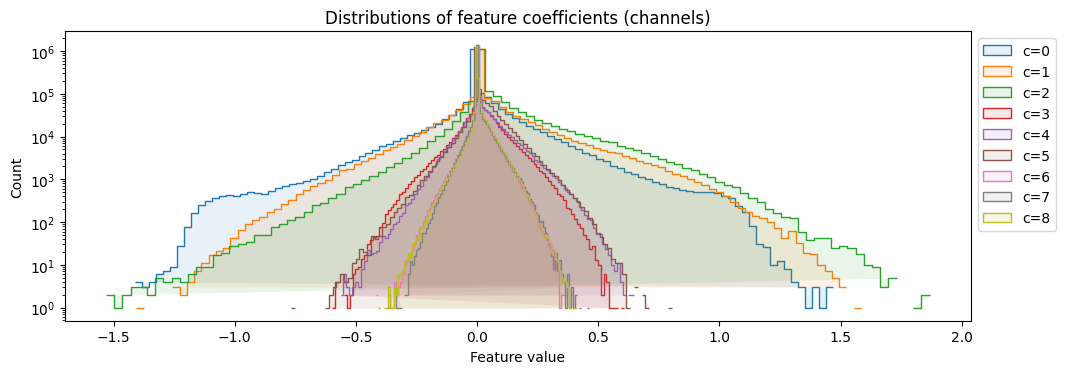

In [ ]:
plot_distributions(peaks, kde=False, log_scale=(False, True))

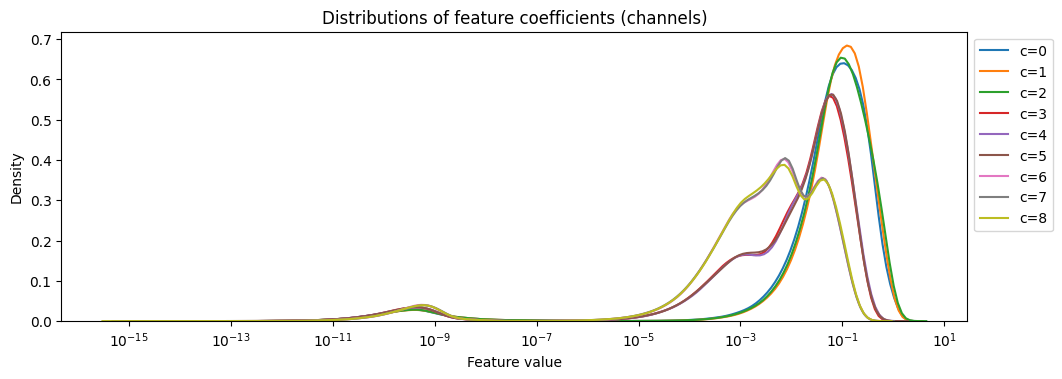

In [ ]:
plot_distributions(np.abs(peaks), filter=True, log_scale=(True, False))

In [ ]:
variances = np.var(peaks, axis=0)
display(variances)

array([0.02343962, 0.02491087, 0.026118  , 0.00291433, 0.00314981,
       0.00295303, 0.00069979, 0.00069205, 0.00071403])

### Low rank fODF approximation

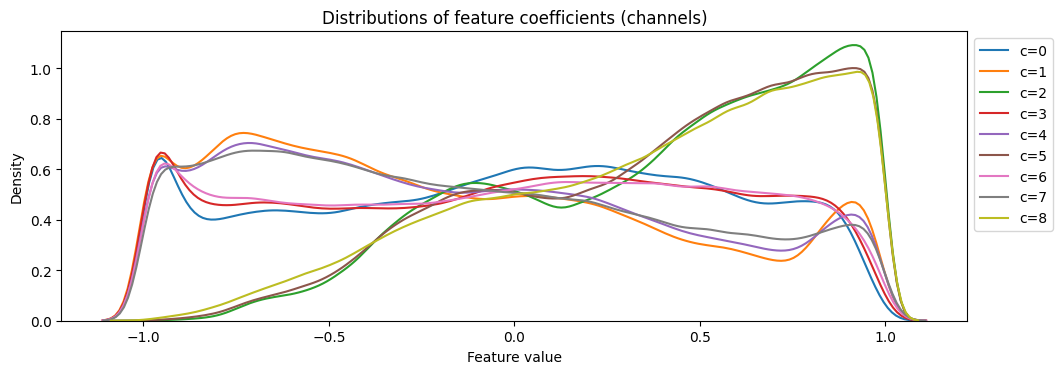

In [ ]:
# Not in log scale!
plot_distributions(rankk)

In [ ]:
variances = np.var(rankk, axis=0)
display(variances)

array([0.15156731, 0.16562331, 0.13337024, 0.16109591, 0.16127051,
       0.13161863, 0.16236299, 0.16024402, 0.13494387])

### fODFs in symmetric tensor representation

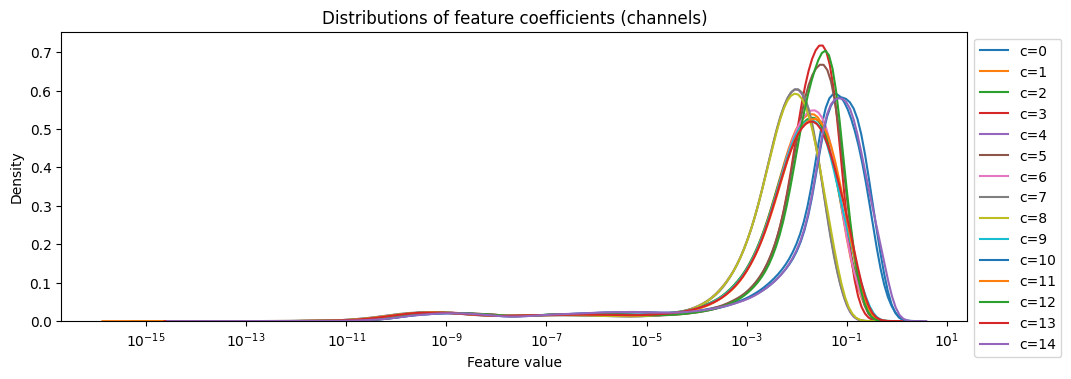

In [ ]:
plot_distributions(np.abs(fodfs), filter=True, log_scale=(True, False))

In [ ]:
order = bd.utils.tensor.get_order(fodfs[0])
multiples = bd.utils.tensor.MULTIPLIER[order]
display(multiples)

variances = np.var(fodfs, axis=0)
display(variances)

[1.0, 4.0, 4.0, 6.0, 12.0, 6.0, 4.0, 12.0, 12.0, 4.0, 1.0, 4.0, 6.0, 4.0, 1.0]

array([0.00849977, 0.0008477 , 0.00098475, 0.00063464, 0.00017679,
       0.00082805, 0.00090984, 0.00018079, 0.00019695, 0.00120275,
       0.00948135, 0.00104771, 0.00089028, 0.00119258, 0.01151114])

### fODFs in spherical harmonics representation

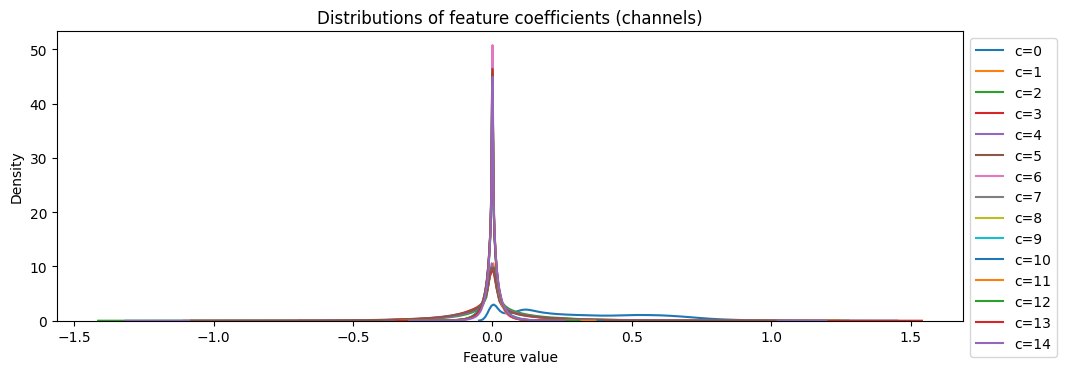

In [ ]:
plot_distributions(fodfs_sh, filter=True, log_scale=(False, False))

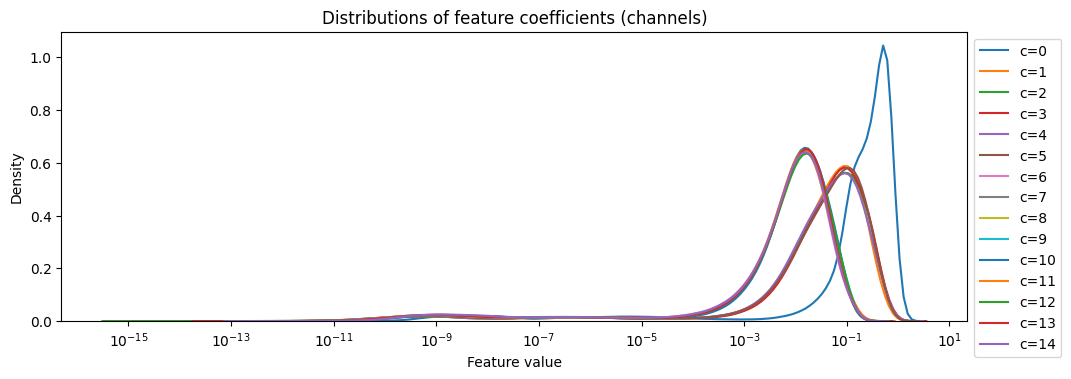

In [ ]:
plot_distributions(np.abs(fodfs_sh), filter=True, log_scale=(True, False))

In [ ]:
variances = np.var(fodfs_sh, axis=0)
display(variances)

array([0.05682603, 0.00964869, 0.01174498, 0.01253219, 0.01149376,
       0.01143606, 0.00041452, 0.00043142, 0.00043927, 0.00049555,
       0.00046288, 0.0004887 , 0.00048259, 0.00044203, 0.00043024])

To me, it seems sensible to scale the variance of the Gaussian noise augmentation with the per-channel variances in all cases except for the low rank approximation representation (but even there it might not hurt). Note that the original implementation uses peaks while not caring about any of this at all.

However, since the variances "only" differ by 1-2 orders of magnitude, it might have no observable effect on the trained model. If we would input the fODFs in SH representation, this seems more necessary.